# Tutorial 04 - Handling spiking data

## Goals

- Describe spike trains through binning and spike density functions
- Describe spike trains by their interspike intervals (ISIs)
- Compute an autocorrelation function (ACF) and crosscorrelation function (CCF)
- Generating fake spike data

## Determine firing rates

In [1]:
# import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt
import scipy.signal

# define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R042-2013-08-18')

In [2]:
# load the info file, which contains experiment-specific information
sys.path.append(data_folder)
import r042d3 as info

In [3]:
# Load spikes (.t and ._t) from this experiment
spikes = nept.load_spikes(data_folder)

In [4]:
# Let's limit our investigation to one neuron
neuron_idx = 31
these_spikes = spikes[neuron_idx]

# And restrict the time so we can more easily see what's going on
start = 2500.0
stop = 2700.0
filtered_spikes = these_spikes.time_slice(start, stop)

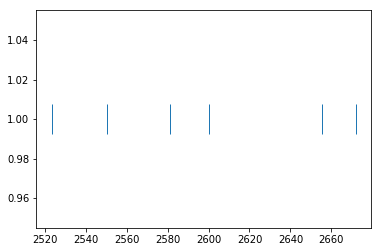

In [5]:
# Plot the spikes
plt.plot(filtered_spikes.time, np.ones(len(filtered_spikes.time)), '|', ms=30)
plt.show()

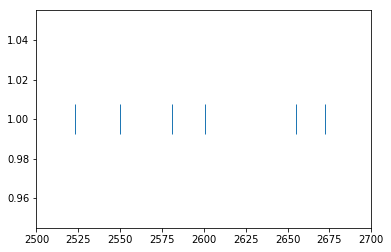

In [6]:
plt.plot(these_spikes.time, np.ones(len(these_spikes.time)), '|', ms=30)
plt.xlim(2500, 2700)
plt.show()

In [7]:
# Create an AnalogSignal used to define the time edges for the binned spikes
edges = nept.AnalogSignal(np.ones(20), np.linspace(start, stop, 20))

In [8]:
# Bin the spikes
window_advance = 0.5
time_edges = nept.get_edges(start, stop, window_advance, lastbin=True)

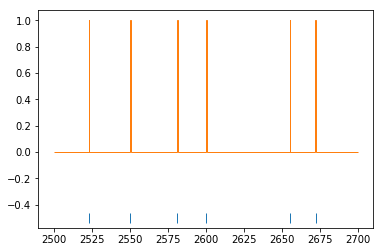

In [9]:
# Plot the spikes
plt.plot(filtered_spikes.time, np.ones(len(filtered_spikes.time))-1.5, '|', ms=10)

# Plot the number of spikes in each bin
plt.hist(filtered_spikes.time, time_edges, histtype='step')
plt.show()

In [10]:
# Now let's look at a spike density function (SDF; convolved spike train)
# for this SDF we need a smaller bin size
bin_size = 0.001

sdf_edges = np.arange(start, stop, bin_size)
sdf_centers = sdf_edges[:-1]+bin_size/2

# Make a gaussian filter
gaussian_window = 1.0 / bin_size
gaussian_std = 0.02 / bin_size

gaussian_kernel = scipy.signal.gaussian(gaussian_window, gaussian_std)
gaussian_kernel /= np.sum(gaussian_kernel)
gaussian_kernel /= bin_size

# Bin the spikes
spike_count = np.histogram(filtered_spikes.time, bins=sdf_edges)[0]

# Convolve the binned spikes by the gaussian filter
convolved_spiketimes = scipy.signal.convolve(spike_count, gaussian_kernel, mode='same')

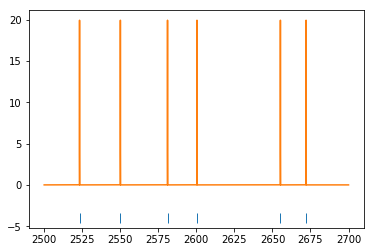

In [11]:
# Plot the spikes
plt.plot(filtered_spikes.time, np.ones(len(filtered_spikes.time))-5, '|', ms=10)

# Plot the spike density function
plt.plot(sdf_centers, convolved_spiketimes)
plt.show()

## Interspike intervals (ISIs)

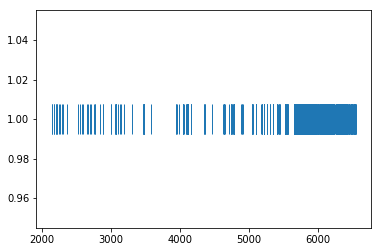

In [12]:
# Let's work with the same neuron as before, this time with the spikes from the entire session. 
# Plot the spikes
plt.plot(these_spikes.time, np.ones(len(these_spikes.time)), '|', ms=30)
plt.show()

In [13]:
# Find the duration of the interspike intervals
isi = np.diff(these_spikes.time)

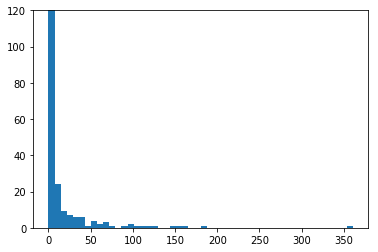

In [14]:
# Plot the binned ISIs
plt.hist(isi, 50)
plt.ylim(0, 120)
plt.show()

## Spike autocorrelation function (ACF)

In [15]:
def autocorrelation(spiketimes, bin_size, max_time):
    """Computes the autocorrelation for an individual spiketrain.
    
    Parameters
    ----------
    spiketimes : np.array
    bin_size : float
    max_time : float
    
    Returns
    -------
    aurocorrelation : np.array
    bin_centers : np.array    
    """
    
    bin_centers = np.arange(-max_time-bin_size, max_time+bin_size, bin_size)
    autocorrelation = np.zeros(bin_centers.shape[0]-1)
    
    for spike in spiketimes:
        relative_spike_time = spiketimes - spike
        
        autocorrelation += np.histogram(relative_spike_time, bin_centers)[0]
    
    bin_centers = bin_centers[2:-1]
    autocorrelation = autocorrelation[1:-1]
    
    # Normalize the autocorrelation
    autocorrelation /= np.max(autocorrelation)
        
    return autocorrelation, bin_centers

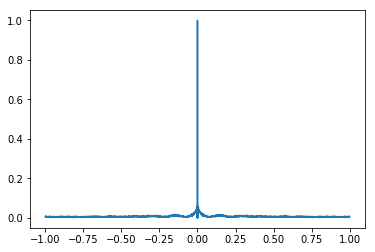

In [16]:
# Find the autocorrelation for our spikes of interest
acf, bin_centers = autocorrelation(these_spikes.time, bin_size=0.001, max_time=1.)

# Plot the autocorrelation
plt.plot(bin_centers, acf)
plt.show()

## Spike cross-correlation function (CCF)

In [17]:
def crosscorrelation(spiketimes1, spiketimes2, bin_size, max_time):
    """Computes the autocorrelation for an individual spiketrain.
    
    Parameters
    ----------
    spiketimes1 : np.array
    spiketimes2 : np.array
    bin_size : float
    max_time : float
    
    Returns
    -------
    crosscorrelation : np.array
    bin_centers : np.array    
    """
    
    bin_centers = np.arange(-max_time-bin_size, max_time+bin_size, bin_size)
    crosscorrelation = np.zeros(bin_centers.shape[0]-1)
    
    for spike in spiketimes1:
        relative_spike_time = spiketimes2 - spike
        
        crosscorrelation += np.histogram(relative_spike_time, bin_centers)[0]
    
    bin_centers = bin_centers[2:-1]
    crosscorrelation = crosscorrelation[1:-1]
    
    # Normalize the crosscorrelation by the number of spikes in the first input
    crosscorrelation /= len(spiketimes1)
        
    return crosscorrelation, bin_centers

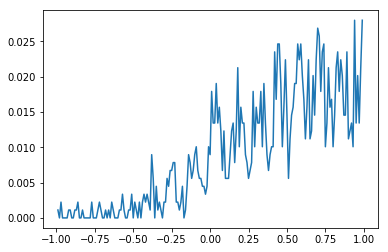

In [18]:
# limit spikes to task times
task_start = info.task_times['task'].start
task_stop = info.task_times['task'].stop

task_spikes = [spiketrain.time_slice(task_start, task_stop) for spiketrain in spikes]

# Find the crosscorrelation for our spikes of interest
idx1 = 73
idx2 = 31

ccf, bin_centers = crosscorrelation(task_spikes[idx1].time, task_spikes[idx2].time, 
                                    bin_size=0.01, max_time=1.)

# Plot the crosscorrelation
plt.plot(bin_centers, ccf)
plt.show()

## Generating fake spike data

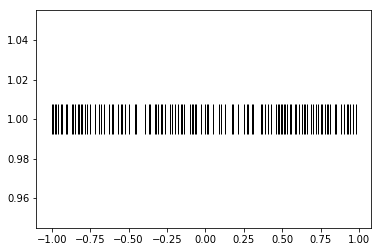

In [19]:
# Generate a fake spike train
dt = 0.01
spiketime = np.arange(-1, 1, dt)

probability = 0.5
random_values = np.random.random((1, len(spiketime)))
spike_idx = np.where(random_values < probability)[1]
toy_spikes = nept.SpikeTrain(spiketime[spike_idx])

# Plot the fake spikes
plt.plot(toy_spikes.time, np.ones(len(toy_spikes.time)), '|', ms=30, color='k')
plt.show()